<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/NewDataset/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

### IceVision

In [ ]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

You need to restart the execution environment:

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from fastai.vision.all import *

In [ ]:
from icevision.all import *

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [ ]:
import glob
import shutil
import operator
import sys
import argparse
import math
from matplotlib import pyplot as plt
import cv2
import json
import os
import re
from pathlib import Path
from imutils.contours import sort_contours
import numpy as np
import imutils
import sys
import statistics as stats
import pandas as pd
import torch
from sklearn.model_selection import train_test_split


In [ ]:
import os
os.chdir('../')
from utils.utils import *

In [ ]:
import numpy as np
import os,shutil,json
import xml.etree.ElementTree as ET
from pathlib import Path

### Trained model

In [ ]:
%%capture
!wget https://www.dropbox.com/s/ak6ay61p8rx345h/modelFasterRCNN_36.pth?dl=1 -O modelFasterRCNN_36.pth

## Dataset

Once we are done with the installation, we load the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/). This dataset is a dataset for Text Detection, Optical Character Recognition, Spatial Layout Analysis and Form Understanding. It's made up of 199 fully annotated forms.

In [ ]:
%%capture
!unzip Facturas.zip

Let's see the structure of this dataset:

In [ ]:
path=Path('Facturas')

### mAP

In [ ]:
MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# # argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")

args = parser.parse_args()

### Predictions






In [ ]:
os.mkdir('input')
os.mkdir('input/ground-truth')
os.mkdir('input/detection-results')

In [ ]:
path='Facturas'
for file in [xml for xml in os.listdir(path) if xml[-1]=='l']:
  txt=open('input/ground-truth/'+file[:-4]+'.txt','w')
  path_file=path+'/'+file
  objeto=ET.parse(path_file)
  objeto = objeto.getroot()
  for bbox in objeto.findall('object'):
    label=bbox.find('name').text
    coords = bbox.find('bndbox')
    xmin,ymin,xmax,ymax = coords.find('xmin').text,coords.find('ymin').text,coords.find('xmax').text,coords.find('ymax').text
    txt.write(label + ' ' + xmin + ' ' + ymin + ' '+ xmax + ' '+ ymax +'\n')
  txt.close()
  

We load a better model that we had trained before:

In [26]:
class_map=ClassMap(['question', 'answer', 'header', 'other'])

In [ ]:
model = faster_rcnn.model(num_classes=len(class_map))
state_dict = torch.load('modelFasterRCNN_36.pth')
model.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
files=['Facturas/'+xml for xml in os.listdir(path) if xml[-1]=='g']

In [ ]:
presize = 1000
size = 800

In [27]:
for f in files:
  f=Path(f)
  txt=open('input/detection-results/'+f.stem+'.txt','w')
  clone=cv2.imread(str(f))
  Y,X,_=clone.shape
  infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size),tfms.A.Normalize()])
  infer_ds = Dataset.from_images([clone], infer_tfms)
  batch, samples = faster_rcnn.build_infer_batch(infer_ds)
  preds = faster_rcnn.predict(model=model, batch=batch,detection_threshold=0.5) 
  labels=preds[0]['labels'] 
  bbox=preds[0]['bboxes']
  for i in tqdm(range(len(labels))):
    x1=bbox[i].xmin-(samples[0]['img'].shape[1]-samples[0]['width'])/2
    y1=bbox[i].ymin
    z1=bbox[i].xmax-(samples[0]['img'].shape[1]-samples[0]['width'])/2
    w1=bbox[i].ymax

    x1=X*x1/samples[0]['width']
    y1=Y*y1/samples[0]['height']
    z1=X*z1/samples[0]['width']
    w1=Y*w1/samples[0]['height']
    txt.write(class_map.get_id(labels[i])+' '+str(preds[0]['scores'][i])+' '+ str(int(x1))+' '+ str(int(y1))+' '+ str(int(z1))+' '+ str(int(w1))+'\n')

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

### Results

In [28]:
mAP()

8.47% = answer AP 
15.35% = header AP 
8.82% = other AP 
17.62% = question AP 
mAP = 12.57%


In [29]:
txt=open('/content/output/output.txt','r')
linea=txt.readline()
gt=[]
dt=[]
while linea!= '# Number of ground-truth objects per class\n':
  linea=txt.readline()
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1])   
txt.readline()
txt.readline()
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])

precision= stats.mean([float(dt[i][1][4:-1])/(float(dt[i][1][4:-1])+float(dt[i][2][3:-1])) for i in range(0,4) if len(dt[i])!=0])
print('precision: ',precision)
recall=stats.mean([float(dt[i][1][4:-1])/float(gt[i])  for i in range(0,4)if len(dt[i])!=0])
print('recall: ',recall)
print('f1-score: ',2*precision*recall/(precision+recall))

precision:  0.3502003832123047
recall:  0.220499817095613
f1-score:  0.27061185681541267


In [ ]:
def openImage(path):
  return cv2.imread(str(path))
  
def showImage(image,h=20,w=15):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(h,w))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(h,w))
    plt.imshow(img2,cmap='gray')
    plt.show()

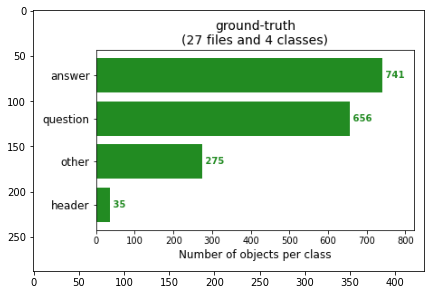

In [ ]:
showImage(openImage('/content/output/ground-truth-info.png'),7,5)

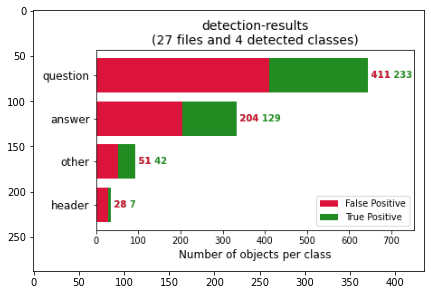

In [ ]:
showImage(openImage('/content/output/detection-results-info.png'),7,5)

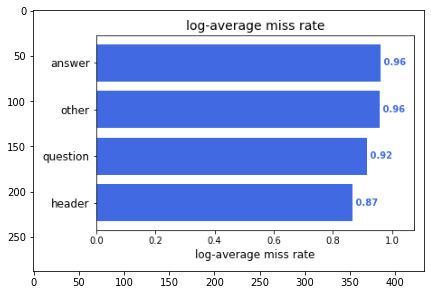

In [ ]:
showImage(openImage('/content/output/lamr.png'),7,5)

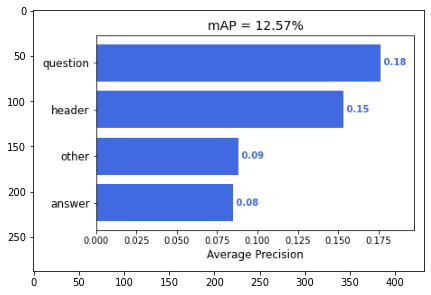

In [ ]:
showImage(openImage('/content/output/mAP.png'),7,5)

### Inference

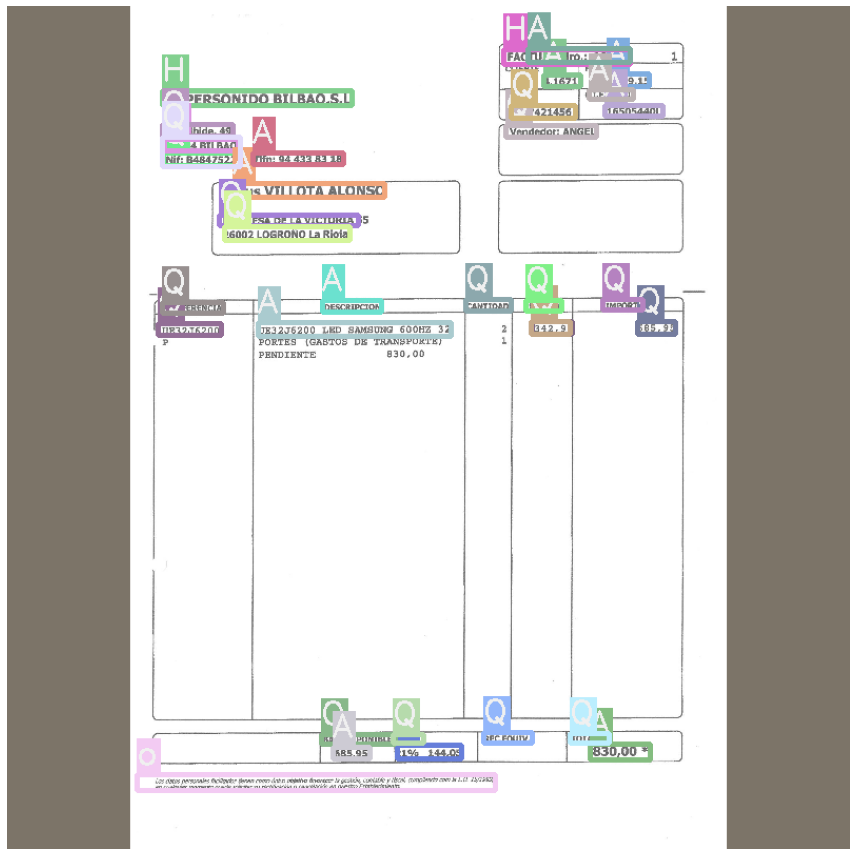

In [36]:
class_map=ClassMap(['Q', 'A', 'H', 'o'])
test_img=[cv2.imread('Facturas/01.jpg')]
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size),tfms.A.Normalize()])
infer_ds = Dataset.from_images(test_img, infer_tfms)
batch, samples = faster_rcnn.build_infer_batch(infer_ds)
preds = faster_rcnn.predict(model=model, batch=batch,detection_threshold=0.5)
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)